In [1]:
from common.torch_utils import get_available_device

device = get_available_device()
device = 'cpu'

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


In [2]:
import torch

from fcos import FocalLoss, CenternessLoss, IoULoss


def total_loss(pred, target, aggregator='sum'):
    aggregator = getattr(torch, aggregator)
    
    target_classes = target['classes']
    target_boxes = target['boxes']
    target_centerness = target['centerness']

    pred_classes = pred['classes']
    pred_boxes = pred['boxes']
    pred_centerness = pred['centerness']

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")
    
    positive_samples = torch.sum(target_classes, axis=-1)  
    positive_mask = positive_samples > 0
    positive_samples_cnt = torch.sum(positive_mask)
    print("Positive samples cnt:", positive_samples_cnt)
    
    class_loss = FocalLoss()(
        pred_classes,
        target_classes.to(pred_classes.device),
    )
    class_loss = aggregator(class_loss) / positive_samples_cnt

    pred_boxes_positive = torch.reshape(pred_boxes[positive_mask], [-1, 4])
    target_boxes_positive = torch.reshape(target_boxes[positive_mask], [-1, 4])
    pred_centerness_positive = pred_centerness[positive_mask]
    target_centerness_positive = target_centerness[positive_mask]

    centerness_loss = CenternessLoss()(
        pred_centerness_positive,
        target_centerness_positive.to(pred_centerness_positive.device),
    )
    centerness_loss = aggregator(centerness_loss) / positive_samples_cnt

    regression_loss = IoULoss()(
        pred_boxes_positive,
        target_boxes_positive.to(pred_boxes_positive.device),
    )
    regression_loss = aggregator(regression_loss) / positive_samples_cnt

    return class_loss, centerness_loss, regression_loss

In [3]:
import time
import torch.optim as optim

from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec
from fcos import FcosDetectionsCodec
from dataset.loader import build_dataloader

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)
aggregator = 'sum'
grad_clipp = 1.

model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=img_res,
).to(device)


train_dataloader = build_dataloader('train', batch_size=4)
optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
# optimizer = optim.Adam(model.parameters())

loss_sample = []
for epoch in range(1):
    for step, (img, boxes, labels) in enumerate(train_dataloader):
        start_stamp = time.time()
        optimizer.zero_grad()

        pred = model(img.to(device))
        
        targets = codec.encode(boxes, labels)

        clf_loss, cntr_loss, regr_loss = total_loss(pred, targets, aggregator=aggregator)
        loss = clf_loss + cntr_loss + regr_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clipp)
        optimizer.step()
        
        loss_sample.append(loss)

        print(f"Step {step} Total loss: {loss}\t\tDuration: {time.time() - start_stamp}")
        print(f"\t\tClassification: {clf_loss}")
        print(f"\t\tCenterness {cntr_loss}")
        print(f"\t\tRegression {regr_loss}")
        print(f"DEBUG")
        print(torch.max(torch.abs(model._core._fext._backbone.conv1.weight)))
        print(torch.max(torch.abs(model._core._fext._backbone.conv1.weight.grad)))
        print()

print('Finished Training')

/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels
/Users/iolkhovsky/Documents/repos/fcos/fcos/codec.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_regression_value = max(torch.tensor(ltrb, dtype=torch.float))


Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(97)
Step 0 Total loss: 3.301492214202881		Duration: 9.394944190979004
		Classification: 1.191566824913025
		Centerness 1.523080825805664
		Regression 0.5868445038795471
DEBUG
tensor(1.9790, grad_fn=<MaxBackward1>)
tensor(0.0021)

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(72)
Step 1 Total loss: 3.8124899864196777		Duration: 9.382638692855835
		Classification: 1.3453761339187622
		Centerness 1.709683895111084
		Regression 0.7574301958084106
DEBUG
tensor(1.9790, grad_fn=<MaxBackward1>)
tensor(0.0040)

Classes (pred / target):

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(86)
Step 17 Total loss: 3.4740724563598633		Duration: 9.058698892593384
		Classification: 1.1937531232833862
		Centerness 1.6902469396591187
		Regression 0.5900724530220032
DEBUG
tensor(1.9790, grad_fn=<MaxBackward1>)
tensor(0.0047)

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(82)
Step 18 Total loss: 3.663137912750244		Duration: 9.301092147827148
		Classification: 1.1921275854110718
		Centerness 1.6995328664779663
		Regression 0.7714775800704956
DEBUG
tensor(1.9790, grad_fn=<MaxBackward1>)
tensor(0.0043)

Classes (pred / tar

KeyboardInterrupt: 

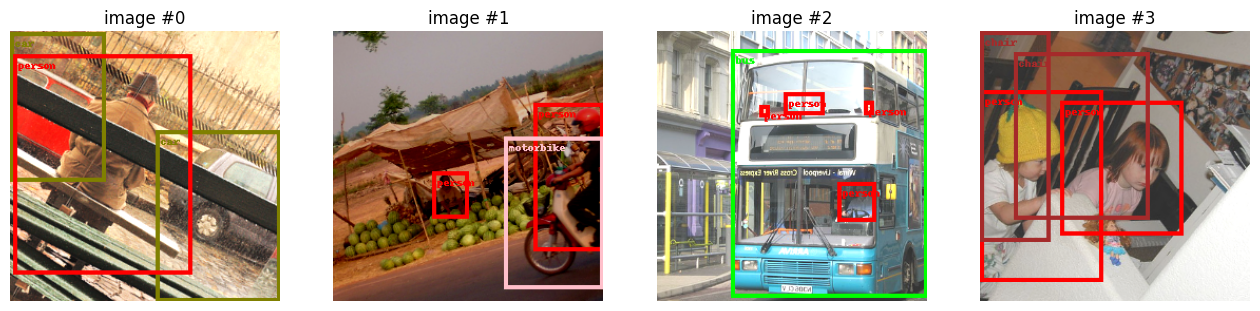

In [4]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

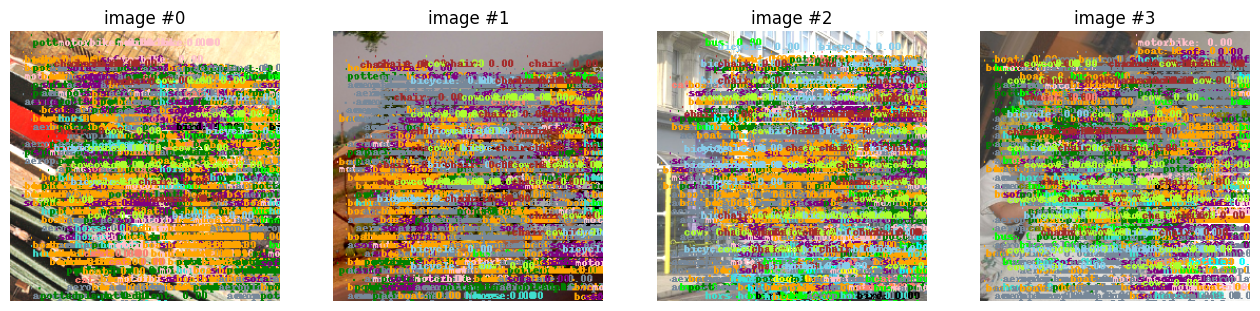

In [8]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    pred_classes = prediction['classes']
    pred_center = prediction['centerness']
    pred_boxes = prediction['boxes']

    for img_idx in range(len(pred_classes)):
        img_classes = pred_classes[img_idx]
        img_centerness = pred_center[img_idx]
        img_boxes = pred_boxes[img_idx]

        final_scores = img_classes * img_centerness
        max_scores, max_indices = torch.max(final_scores, axis=1)
        mask = max_scores > threshold

        filtered_scores = max_scores[mask]
        filtered_labels = max_indices[mask]
        filtered_boxes = img_boxes[mask]

        for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
            scores[img_idx].append(score)
            labels[img_idx].append(label)
            boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img.to('cpu'), model(img.to('cpu')), LabelsCodec(), 0.001)